# Fitness by scoring

Apziva project #3<br>
2023 07 17

__Summary:__
* Each candidate is automatically provided with a preliminary fitness: __artificial target variable__.
* This fitness is calculated based on the __lemmas__ of the __job title__ and on the lemmas of the __keywords__.
* Lemmatization is based on
    * the __Spacy__ library.
    * the language core: `en_core_web_sm`.

## TOC: <a class="anchor" id="TOC"></a>
* [Utilities](#Utilities)
* [General settings](#GeneralSetting)
* [Data retrieval](#DataManagement)
* [EDA](#EDA1)
    * [Language](#EDAOnLanguage)
    * [Duplicates](#EDAOnDuplicates)
* [DataCleaning](#DataCleaning)
    * [Connections](#DataCleaningConnections)
    * [Job titles](#DataCleaningJobTitles)
* [Lemmatization](#Lemmatization)
* [EDA on connections and lemmas](#EDAOnLemmas)
* [Fitness by scoring](#FitnessByScoring)   

## Utilities <a class="anchor" id="Utilities"></a>
[TOC](#TOC)

In [1]:
# own libraries
import Utilities as u
import MachineLearning as ml

# activate changes in libraries
import importlib
importlib.reload(u)
importlib.reload(ml)

# aliases
from Utilities import TypeChecker as t
from Utilities import PrintAlias as p

## General settings <a class="anchor" id="GeneralSetting"></a>
[TOC](#TOC)

In [2]:
# constants

# general
cfltRandomSeed = 42 # any number

# files
cstrSourcePath = "../data/raw/"
cstrSourceFile = "PotentialTalentsUTF8.csv"

cstrOutputPath = "../data/interim/"
cstrOutputFile = "RankedCandidates.csv"

# qualifications searched for by TSMC
cintGivenByTask = 1
cintSynonyms = 2
intKeywordVersion = cintGivenByTask # adjust here!
if intKeywordVersion == cintGivenByTask:
    lstrQualificationsSearchedFor = ["Aspiring human resources","seeking human resources"]
elif intKeywordVersion == cintSynonyms:
    lstrQualificationsSearchedFor = ["Aspiring human resources","seeking human resources", 
                                     "aspiring HR professional", "seeking Staffing position", "Recruiting Position"]
else:
    p("Strange keyword version.")
    
# define relevant part(s) of speech (POS)
lstrPOS = ["ADJ","ADP","ADV","AUX","CCONJ","DET","INTJ","NOUN","NUM","PART","PRON","PROPN","PUNCT","SCONJ","SYM","VERB","X"] # full Spacy set
lstrPOS = ["NOUN","ADJ","VERB"] # maximum reasonble subset
lstrPOS = ["NOUN","ADJ","VERB"] # subset used

## Data retrieval <a class="anchor" id="DataManagement"></a>
[TOC](#TOC)

In [3]:
import pandas as pd

# get raw data
# - UTF8 required for international, non-ASCII characters (e.g. "İzmir, Türkiye")
dfrRaw = pd.read_csv(f"{cstrSourcePath}/{cstrSourceFile}", encoding='utf-8', sep=';')
dfrRaw

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
...,...,...,...,...,...
99,100,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri",103,NaN
100,101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,NaN
101,102,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,NaN
102,103,Always set them up for Success,Greater Los Angeles Area,500+,NaN


# EDA<a class="anchor" id="EDA1"></a>
[TOC](#TOC)

## Language<a class="anchor" id="EDAOnLanguage"></a>
[TOC](#TOC)

In [4]:
for strColumn in ["job_title","location"]:
    p("Column".upper(),strColumn)
    p("¦".join(dfrRaw[strColumn]))

COLUMN job_title
2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional¦Native English Teacher at EPIK (English Program in Korea)¦Aspiring Human Resources Professional¦People Development Coordinator at Ryan¦Advisory Board Member at Celal Bayar University¦Aspiring Human Resources Specialist¦Student at Humber College and Aspiring Human Resources Generalist¦HR Senior Specialist¦Student at Humber College and Aspiring Human Resources Generalist¦Seeking Human Resources HRIS and Generalist Positions¦Student at Chapman University¦SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR¦Human Resources Coordinator at InterContinental Buckhead Atlanta¦2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional¦2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional¦Native English Teacher at EPIK (English

__Observations:__
* Job titles are all in English.
* Locations are in different languages, but mostly in English, too. Exceptions: "Kanada" (German, Swedish etc.), "İzmir, Türkiye" (Turkish).

## Duplicates <a class="anchor" id="EDAOnDuplicates"></a>
[TOC](#TOC)

In [5]:
# get duplicates
# - 3 columns
# - keep first record of duplicate group
lstrRelevantColumns = ["job_title", "location", "connection"]
srsDuplicateMask = dfrRaw.duplicated(subset=lstrRelevantColumns, keep="first")
dfrDuplicates = dfrRaw[srsDuplicateMask]

cintExamples = 5
p("Duplicates".upper())
p(f"- columns considered: {', '.join(lstrRelevantColumns)}")
p(f"- count:   {dfrDuplicates.shape[0]}")
p(f"- portion: {round(100*dfrDuplicates.shape[0]/dfrRaw.shape[0],1)}%")
p(f"- {cintExamples} examples:")
dfrDuplicates.head(cintExamples)

DUPLICATES
- columns considered: job_title, location, connection
- count:   51
- portion: 49.0%
- 5 examples:


,id,job_title,location,connection,fit
8,9,Student at Humber College and Aspiring Human R...,Kanada,61,NaN
13,14,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
14,15,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
15,16,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
16,17,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN


__Considerations:__
* There is a __high number__ of duplicates:
    * There are even duplicate groups with __more than 2 members__.
* It is __little probable__ that identical wordings and identical connection counts arise by pure chance.
    * The duplicates could arise from __different TSMC members__ who by chance collect information on identical candidates.
    * This suggests deleting the duplicates.
    * On the other hand, the task description indicates that the ID's refer to different individuals.
* Decision:
    * In a real project, I would ask the customer how these duplicates are to be explained for.
    * Without this option, I __keep the duplicates__, assuming that they indeed __refer to different individuals__.
    * Later in the project, one could argue that starring a candidate automatically stars all duplicates of the starred condidate too.
        * Without further information from the clients side, I decide not to do that.
    * The decision has little impact on the project.

# Data cleaning <a class="anchor" id="DataCleaning"></a>
[TOC](#TOC)

## Connections <a class="anchor" id="DataCleaningConnections"></a>
[TOC](#TOC)

In [6]:
p("Before".upper())
u.DisplayDataFrame(dfrRaw.head(3))

dfrConnections = dfrRaw.copy()

# replace "500+" with "500"
dfrConnections["connection"] = dfrConnections["connection"].str.replace("500\+", "500", regex=True)

# convert to integer
dfrConnections["connection"] = pd.to_numeric(dfrConnections["connection"], errors="coerce").fillna(0).astype(int)

p("After".upper())
u.DisplayDataFrame(dfrConnections.head(3))

BEFORE


,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN


AFTER


,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN


## Job titles <a class="anchor" id="DataCleaningJobTitles"></a>
[TOC](#TOC)

In [7]:
def JobTitleAdjusted(strJobtitle):
    '''
    Adjusts job titles (and qualifications) to optimize POS recognition (part of speech recognition).
    
    When       Who What
    2023 07 24 dh  Created
    '''
    strJobtitle = strJobtitle.replace("|", ",")
    strJobtitle = strJobtitle.replace(" ,", ",")
    strJobtitle = strJobtitle.replace("  ", " ")
    lstrWords = strJobtitle.split()
    lstrWordsAdjusted = [strWord.upper() if strWord.isupper() else strWord.lower() for strWord in lstrWords]
    strConnected = ' '.join(lstrWordsAdjusted)
    return strConnected[0].upper() + strConnected[1:]
if False:
    strTester = "aspiring HR manager | 80%, 100%"
    p(JobTitleAdjusted(strTester))

In [8]:
dfrJobTitlesCleaned = dfrConnections.copy()

p("Before".upper())
u.DisplayDataFrame(dfrJobTitlesCleaned[["job_title"]].tail())

# delete some characters
dfrJobTitlesCleaned['job_title'] = dfrJobTitlesCleaned['job_title'].apply(JobTitleAdjusted)

p("After".upper())
u.DisplayDataFrame(dfrJobTitlesCleaned[["job_title"]].tail())

BEFORE


,job_title
99,Aspiring Human Resources Manager | Graduating ...
100,Human Resources Generalist at Loparex
101,Business Intelligence and Analytics at Travelers
102,Always set them up for Success
103,Director Of Administration at Excellence Logging


AFTER


,job_title
99,"Aspiring human resources manager, graduating m..."
100,Human resources generalist at loparex
101,Business intelligence and analytics at travelers
102,Always set them up for success
103,Director of administration at excellence logging


# Lemmatization <a class="anchor" id="Lemmatization"></a>
[TOC](#TOC)

__Considerations on text-to-number conversion:__
* A standard approach is a bag-of-word, using libraries such as:
    * ```import nltk```
    * ```from nltk.tokenize import word_tokenize```
    * ```from nltk.corpus import stopwords```
* Here, I lemmatization approach is preferable:
    * __No distinction__ between plural or verb __forms__.
    * Restriction to the __most meaningful POS__ (parts of speech).
    * __Dropping named entities__ (which are frequent in this dataset).

In [9]:
# installation:
# - !pip install spacy
# - !python -m spacy download en_core_web_sm

In [10]:
import spacy

# load the English language model
objNLP = spacy.load("en_core_web_sm")

In [11]:
def LemmaSet(strText):
    '''
    Extracts set of lemmas of a text.
    
    When       Who What
    2023 07 24 dh  Created
    '''
    objDocument = objNLP(strText)
    lstrLemmas = [objToken.lemma_.lower() for objToken in objDocument if objToken.pos_ in lstrPOS]
    sstrLemmas = set(lstrLemmas)
    return sstrLemmas

if False:
    p(LemmaSet(JobTitleAdjusted("Human resource specialist")))
    p(LemmaSet(JobTitleAdjusted("Excellent Specialist HR")))
    p(LemmaSet(JobTitleAdjusted("  HR Specialist in Canada: car industry")))

,id,job_title,location,connection,fit,L_graduate,L_professional,L_cum,L_human,L_resource,...,L_entry,L_loparex,L_analytic,L_intelligence,L_traveler,L_set,L_success,L_excellence,L_administration,L_log
0,1,2019 C.T. bauer college of business graduate (...,"Houston, Texas",85,NaN,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Native english teacher at EPIK (english progra...,Kanada,500,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,NaN,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


Shape: (104, 137)
10 examples: L_graduate, L_professional, L_cum, L_human, L_resource, L_business, L_magna, L_aspire, L_laude, L_native

LEMMA COUNTS


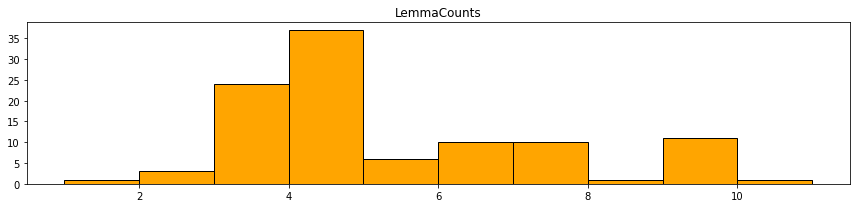

,count,min,50%,max
LemmaCounts,104.0,1.0,4.0,11.0


In [12]:
# init
dfrLemmas = dfrJobTitlesCleaned.copy()

# get unique lemmas from the entire dataset
sstrAllLemmas = set()
lintLemmaCounts = []
i=0
for intRecord,strText in enumerate(dfrLemmas["job_title"]):
    sstrLemmas = LemmaSet(strText)
    lintLemmaCounts.append(len(sstrLemmas))
    for strLemma in sstrLemmas:
        strLemmaColumn = f"L_{strLemma}"
        if strLemma not in sstrAllLemmas:
            dfrLemmas[strLemmaColumn] = 0
            sstrAllLemmas.add(strLemma)
        dfrLemmas.loc[intRecord, strLemmaColumn] += 1
        dfrLemmas = dfrLemmas.copy()

# feedback    
cintExamples = 10
u.DisplayDataFrame(dfrLemmas.head(3))
p("Shape:",dfrLemmas.shape)
p(f"{cintExamples} examples:",", ".join(dfrLemmas.columns[5:5+cintExamples]))
p()
p("Lemma counts".upper())
dfrLemmaCounts = pd.DataFrame({"LemmaCounts":lintLemmaCounts})
ml.DrawDistributionPlots(dfrLemmaCounts,["LemmaCounts"],intDiagramColumns=1,
    intBins=10,fltTotalWidth=12,fltTotalHeight=3,
)
u.DisplayDataFrame(dfrLemmaCounts.describe().T[["count","min","50%","max"]])

# EDA on connections and lemmas <a class="anchor" id="EDAOnLemmas"></a>
[TOC](#TOC)

CONNECTIONS


,count,mean,std,min,25%,50%,75%,max
connection,104.0,262.663462,222.602812,1.0,47.0,193.0,500.0,500.0


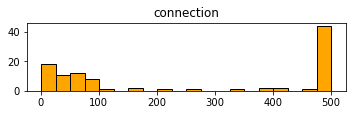


FREQUENCY OF LEMMAS
- sorted by mean
- top 30 lemmas
- rounded to 3 digits


,mean
L_human,0.587
L_resource,0.587
L_aspire,0.337
L_professional,0.202
L_student,0.154
L_seek,0.144
L_generalist,0.135
L_specialist,0.115
L_business,0.106
L_coordinator,0.096


In [13]:
p("Connections".upper())
u.DisplayDataFrame(dfrLemmas[["connection"]].describe().T)
ml.DrawDistributionPlots(dfrLemmas, ["connection"],
    intDiagramColumns=1,intBins=20,fltTotalWidth=5)
p()

cintTopExamples = 30
cintDigits = 3
p("Frequency of lemmas".upper())
p("- sorted by mean")
p(f"- top {cintTopExamples} lemmas")
p(f"- rounded to {cintDigits} digits")
dfrResult = dfrLemmas.describe().drop(["id","connection","fit"],axis=1).T[["mean"]]
u.DisplayDataFrame(dfrResult.sort_values("mean", ascending=False).round(cintDigits).head(cintTopExamples))

__Observations:__
* The number of connections is probably skewed positively (long right-hand tail).
    * The uncertainty results from the unknown meaning of "500+".
    * It may be reasonable to build 3 classes, e.g. <100, <=500, >500.
* The most frequent lemma is "human" and "resource", either contained in 59% of the records.
* "HR" is present too, but 10 times less frequent.

# Fitness by scoring <a class="anchor" id="FitnessByScoring"></a>
[TOC](#TOC)

In [14]:
# check
p("Current set of lemmas:".upper())
p(" ".join(sstrAllLemmas))
p("Count:", len(sstrAllLemmas))
p()

CURRENT SET OF LEMMAS:
state loparex traveler lead success marketing business art army center native college benefit brand relocation cum system specialist open help inclusive world senior magna analyst recruit engineer partner program aspire service position medical people level major representative staffing procedure official endemol hr energy generalist member organization biology lab information programmer human software coordinator opportunity conflict liberal recruiter chapman love university management set employment delphi care resource groupe compensation community laude work hardware admission talent staff teacher shine office analytic excellence payroll administrative science intelligence board retail team portfolio leader log westfield seek travel woodland advisory luxottica policy energetic undergraduate beach administration focus executive schwan paint retire professional environmental kokomo assistant manager development internship junior experienced student passionate l

In [15]:
# lemmatize qualification strings ('keywords')
lsstrQualificationLemmas = []
for strQualificationSearchedFor in lstrQualificationsSearchedFor:
    strQualificationSearchedFor = JobTitleAdjusted(strQualificationSearchedFor)
    sstrQualificationLemmas = LemmaSet(strQualificationSearchedFor)
    lsstrQualificationLemmas.append(sstrQualificationLemmas)

p()
p("Qualification lemmas:".upper())
p(lsstrQualificationLemmas)


QUALIFICATION LEMMAS:
[{'aspire', 'resource', 'human'}, {'resource', 'seek', 'human'}]


CANDIDATES SORTED BY FITNESS ESTIMATES


,job_title,fit
99,"Aspiring human resources manager, graduating may 2020, seeking an entry-level human resources position in st. louis",1.00
28,Aspiring human resources management student seeking an internship,1.00
26,Aspiring human resources management student seeking an internship,1.00
72,"Aspiring human resources manager, seeking internship in human resources.",1.00
0,2019 C.T. bauer college of business graduate (magna cum laude) and aspiring human resources professional,0.83
...,...,...
15,Native english teacher at EPIK (english program in korea),0.00
60,HR senior specialist,0.00
62,Student at chapman university,0.00
63,"SVP, CHRO, marketing & communications, CSR officer, ENGIE, houston, the woodlands, energy, GPHR, SPHR",0.00



DISTRIBUTION OF FITNESS


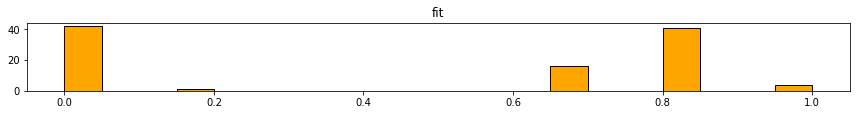

In [16]:
dfrFitness = dfrLemmas.copy()

# collect all columns of dataframe dfrFitness that start with "L_" and drop "L_"
lstrAllLemmas = [column[2:] for column in dfrFitness.columns if column.startswith("L_")]

# loop through the records
for intIndex, srsRow in dfrFitness.iterrows():
    
    #  init score
    intScore = 0
    
    # loop through the list of qualification lemmas
    # - lemmas in several qualification lemma sets yield several scores
    # - e.g. "human" in both keywords yield 2 scores if "human" contained in job title.
    for sstrQualificationLemmas in lsstrQualificationLemmas:
        for strLemma in sstrQualificationLemmas:
            if strLemma in lstrAllLemmas:
                strColumn = "L_" + strLemma
                intScore += srsRow[f"L_{strLemma}"]

    # save to fitness column
    dfrFitness.at[intIndex, "fit"] = intScore
    
# transform fitness to range 0 to 1
cintDigits = 2
intMaxValue = dfrFitness["fit"].max()
dfrFitness["fit"] = dfrFitness["fit"].apply(lambda x: (x / intMaxValue) if intMaxValue != 0 else 0)
dfrFitness["fit"] = dfrFitness["fit"].round(cintDigits)
u.ToDisk(dfrFitness,"dfrFitnessFromScoring","models")

# best fitnesses on top
dfrFitness.sort_values("fit",ascending = False, inplace=True)

# check
p("Candidates sorted by fitness estimates".upper())
pd.set_option('display.max_colwidth', 170)
u.DisplayDataFrame(dfrFitness[["job_title","fit"]])
pd.reset_option('display.max_colwidth')

p()
p("Distribution of fitness".upper())
ml.DrawDistributionPlots(dfrFitness, ["fit"], intDiagramColumns=1, intBins=20)

__Comment:__
* Record 60 does not get any scores because the abbreviation "HR" is not in the keywords, only the full string "human resources".